In [10]:
import pandas as pd
import numpy as np
import os
np.random.seed(42)
%load_ext autoreload
%autoreload 2

# === Paths ===
path_in = os.path.join("../Data")  # parent directory
file_path = os.path.join(path_in, "dataset5-cellb.xlsx")
df = pd.read_excel(file_path)
df["INDOOR_TEMP"] = df[["rb_zone_air_temp1_C", "rb_zone_air_temp2_C"]].mean(axis=1)
df['PHI_H']=df['rb_sup_air_flow_cmh']/3600*1.2*(df['rb_sup_air_temp_C']-df['INDOOR_TEMP'])*1005
# Rename columns
rename_mapping = {
        'oat_C': 'OUTDOOR_TEMP',
        'global_irradiance_Wm2': 'PYRANOMETER',
    }
df = df.rename(columns=rename_mapping)
# Convert 't' to datetime and set as index

df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df = df.resample("30min").mean()
df=df[df.index>'2020-07-21']
surface_area = 57  # m² 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


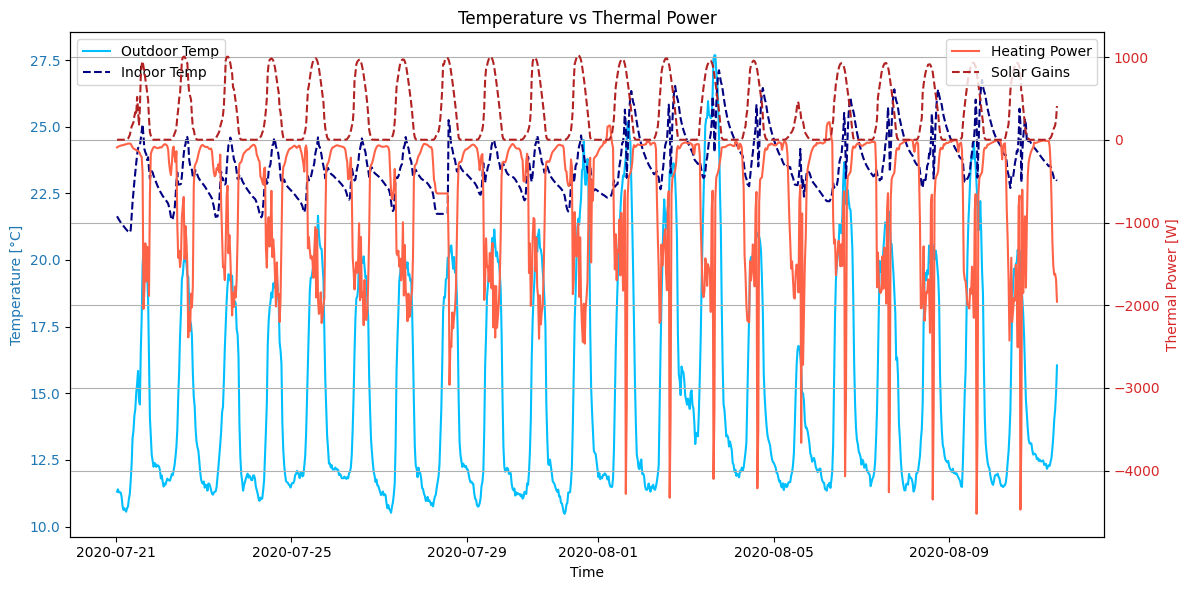

In [11]:
import matplotlib.pyplot as plt

# Δημιουργία figure και άξονα
fig, ax1 = plt.subplots(figsize=(12, 6))

# Πρώτος άξονας - Θερμοκρασίες
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature [°C]', color=color)
ax1.plot(df.index, df['OUTDOOR_TEMP'], label='Outdoor Temp', color='deepskyblue', linestyle='-')
ax1.plot(df.index, df['INDOOR_TEMP'], label='Indoor Temp', color='navy', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Δεύτερος άξονας - Θερμικές ισχείς
ax2 = ax1.twinx()  # Δεύτερος άξονας που μοιράζεται τον ίδιο x-άξονα
color = 'tab:red'
ax2.set_ylabel('Thermal Power [W]', color=color)
ax2.plot(df.index, df['PHI_H'], label='Heating Power', color='tomato')
ax2.plot(df.index, df['PYRANOMETER'], label='Solar Gains', color='firebrick', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Temperature vs Thermal Power')
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
split_index = int(0.8 * len(df))
end_index = int(len(df)) 
train_df = df.iloc[:split_index]
val_df = df.iloc[split_index:end_index]

### Run a single simulation for 1R1C. This is mandatory to validate that everything is work properly and also validate the for a single random initialize run the output may not by the glabal optimum.

In [13]:
import sys
sys.path.append(os.path.abspath(".."))  

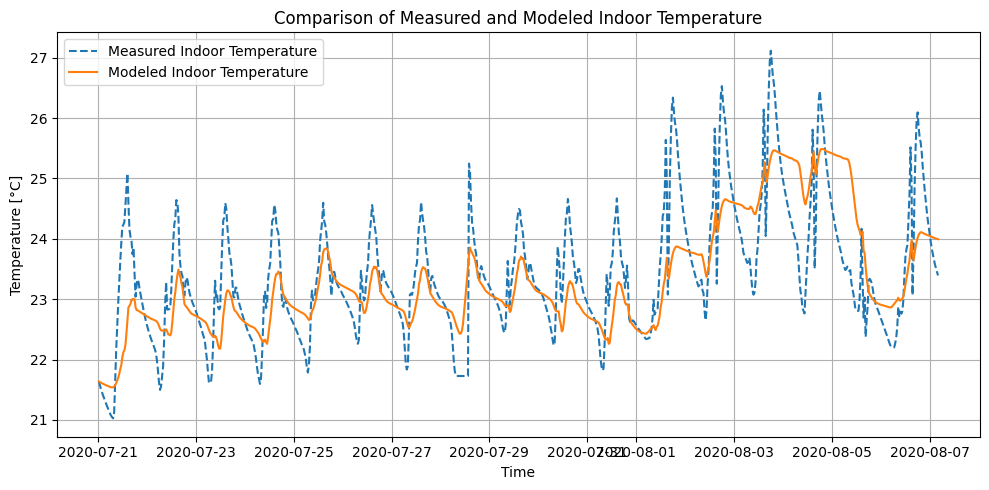

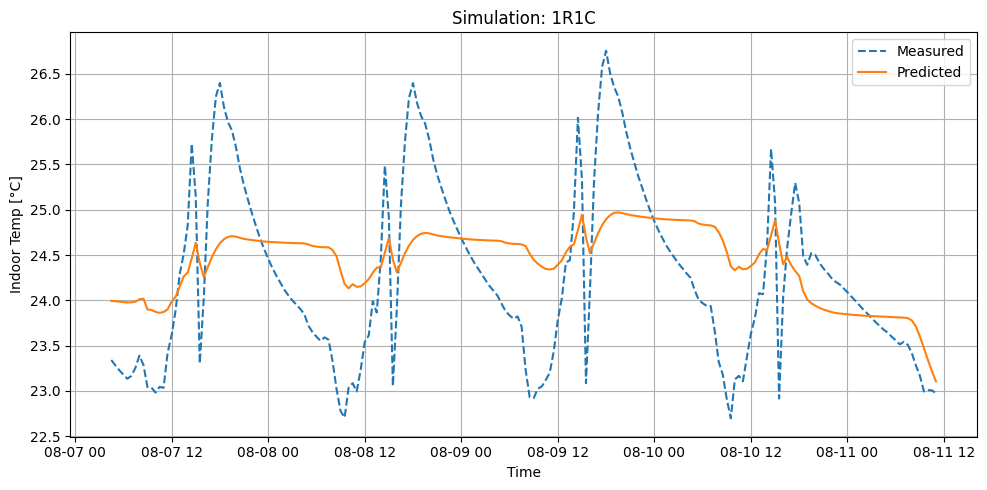

Training RMSE: 0.7812
Validation RMSE: 0.8376


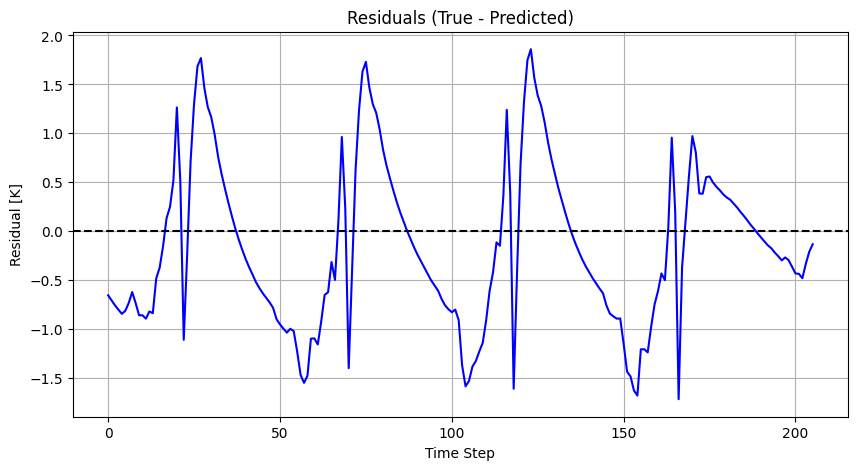

In [28]:
from FinalToolModels.models import *
from FinalToolModels.simulate import *
from FinalToolModels.plot import *
from FinalToolModels.train import *


# --- Bounds ---
bounds_1r1c = {
    "R_in_a": (0.0005, 0.8),
    "C_in": (1e4, 1e10),
    "Ain": (0.001, 0.3 * surface_area)
}

# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="1R1C",
    bounds=bounds_1r1c,
    show_plot=True
)
last_index = max(model.T_in.index_set())


# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tin": model.T_in[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true, val_pred = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="1R1C",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Training RMSE: {np.sqrt(model.obj()):.4f}")
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)


In [29]:
best_model, best_parameters, best_initialization, all_trials = train_greybox_model(
    train_df=train_df,
    model_type="1R1C",    # ➔ Select the model type you want to train
    bounds=bounds_1r1c,   # ➔ The bounds you want to use
    solver_name="ipopt",  # ➔ What solver you want to use
    num_trials=10,        # ➔ How many trials you want to run
    deltaT=1800,          # ➔ The time step of the data in seconds
    show_plot=False        # ➔ If you want to show the plot of the models (True/False
)
all_trials_1r1c=all_trials.copy()

[Trial 1] RMSE = 1.6147, Init: {'R_in_a': 0.09611559962767223, 'C_in': 7132450739.782078, 'Ain': 13.009663546300326}
 parameters: {'R_in_a': 0.7999986148326576, 'C_in': 6353236149.966422, 'Ain': 17.10000014381172, 'fh': 1, 'Objective': 2.6072594795039894, 'Solve_time': 0.03265523910522461}
[Trial 2] RMSE = 1.6665, Init: {'R_in_a': 0.4492411194568123, 'C_in': 7709674089.873811, 'Ain': 8.444410902234715}
 parameters: {'R_in_a': 0.7999984640268522, 'C_in': 7238025967.615863, 'Ain': 17.100000141693076, 'fh': 1, 'Objective': 2.777367214822021, 'Solve_time': 0.030568838119506836}
[Trial 3] RMSE = 0.7812, Init: {'R_in_a': 0.4184248970909043, 'C_in': 4275415908.1753125, 'Ain': 0.43564164819728357}
 parameters: {'R_in_a': 0.799999671216225, 'C_in': 17079053.676647518, 'Ain': 2.5795214036090597, 'fh': 1, 'Objective': 0.6102935289892927, 'Solve_time': 0.06108999252319336}
[Trial 4] RMSE = 0.7812, Init: {'R_in_a': 0.08675919588114692, 'C_in': 314301542.57548565, 'Ain': 10.88298162219938}
 paramete

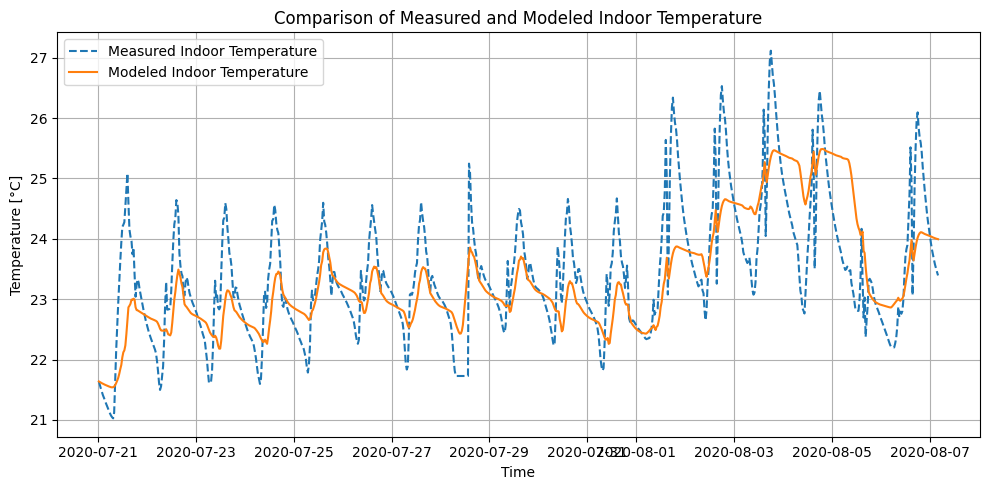

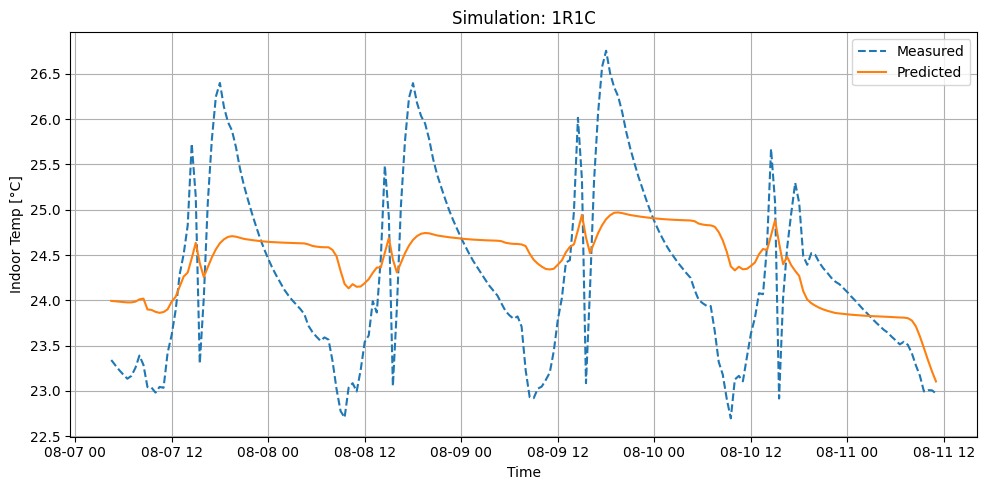

Training RMSE: 0.7812
Validation RMSE: 0.8376


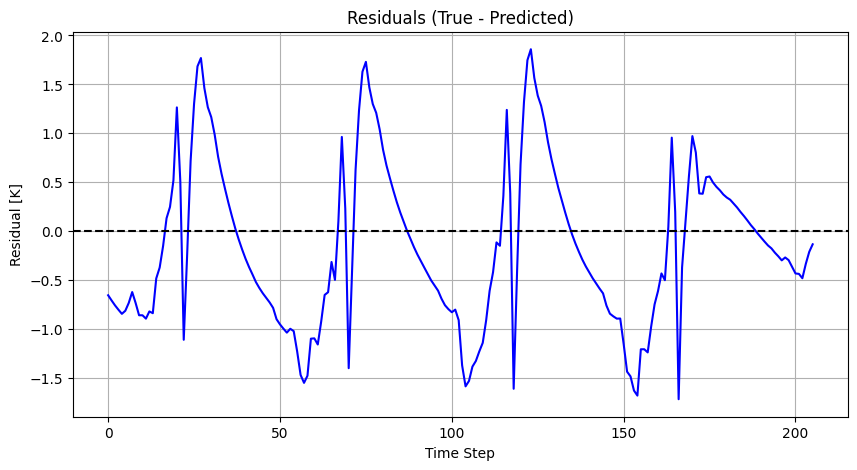

In [30]:
# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="1R1C",
    bounds=bounds_1r1c,
    initialization=best_initialization,
    show_plot=True
)

# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tin": model.T_in[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true, val_pred = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="1R1C",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Training RMSE: {np.sqrt(model.obj()):.4f}")
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)


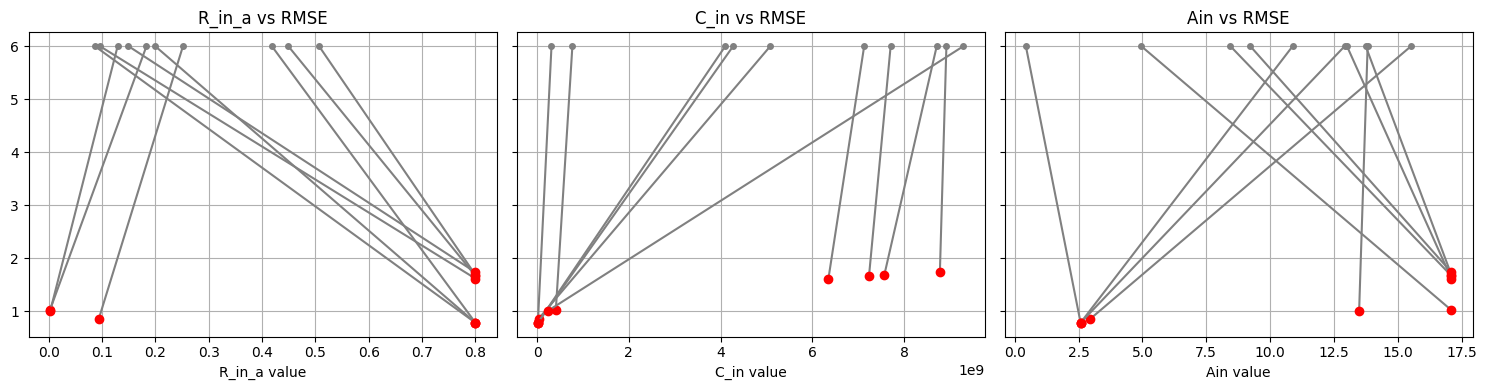

Best Objective achieved in 3 out of 10 trials.
Success rate: 30.00%
Best Objective was equal to 0.6102935289892927
Mean RMSE: 1.58
RMSE Std. Dev.: 1.07


In [31]:
param_list = ['R_in_a', 'C_in', 'Ain']

plot_parameters_vs_rmse_multi(all_trials_1r1c, param_list, y_start=6, rmse_threshold=6)

# Calculate the best (lowest) objective value found
best_obj = all_trials_1r1c['Objective'].min()
mean_obj = all_trials_1r1c["Objective"].mean()
std_obj = all_trials_1r1c["Objective"].std()

# Check how many trials match this objective value up to 6 decimal places
# This allows for small numerical tolerance in floating-point comparisons
matches = (np.round(all_trials_1r1c['Objective'], 5) == np.round(best_obj, 5))

# Count how many times the best value was achieved (within tolerance)
n_matches = matches.sum()

# Total number of trials (rows)
n_total = len(all_trials_1r1c)

# Calculate success rate in percentage
success_rate = 100 * n_matches / n_total

# Print a summary message
print(f"Best Objective achieved in {n_matches} out of {n_total} trials.")
print(f"Success rate: {success_rate:.2f}%")
print(f"Best Objective was equal to {best_obj}")
print(f"Mean RMSE: {mean_obj:.2f}")
print(f"RMSE Std. Dev.: {std_obj:.2f}")

### The second Model is the 2R2C. The same process will be made.

WARNING (W1002): Setting Var 'Ain' to a numeric value `20` outside the bounds
(0.001, 17.099999999999998).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002


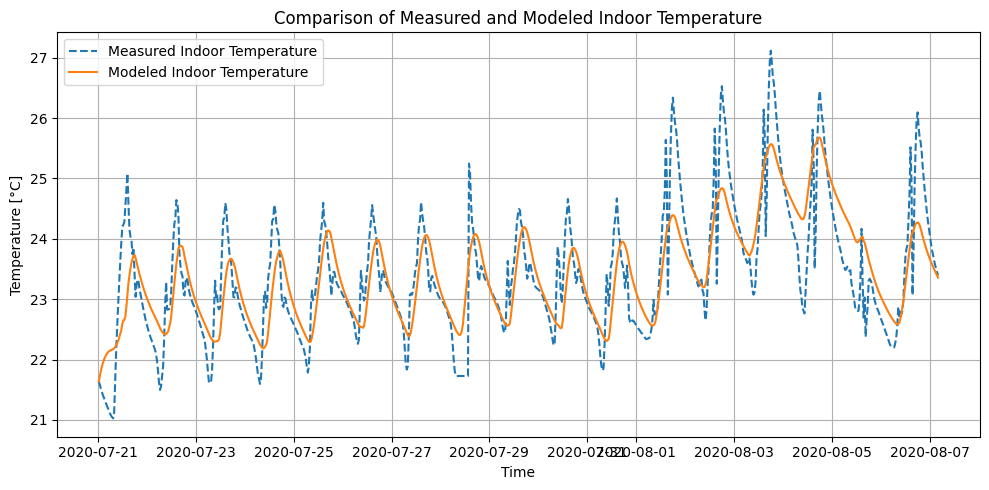

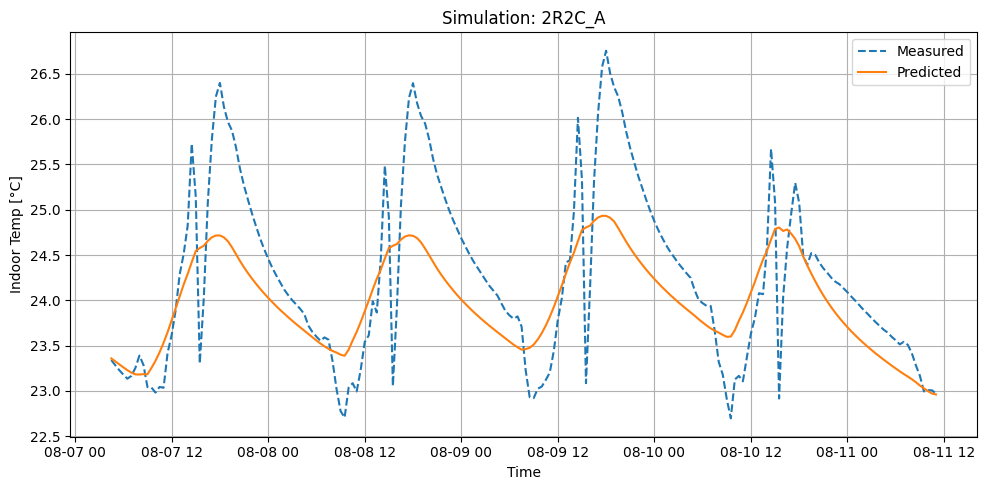

Training RMSE: 0.6396
Validation RMSE: 0.6954


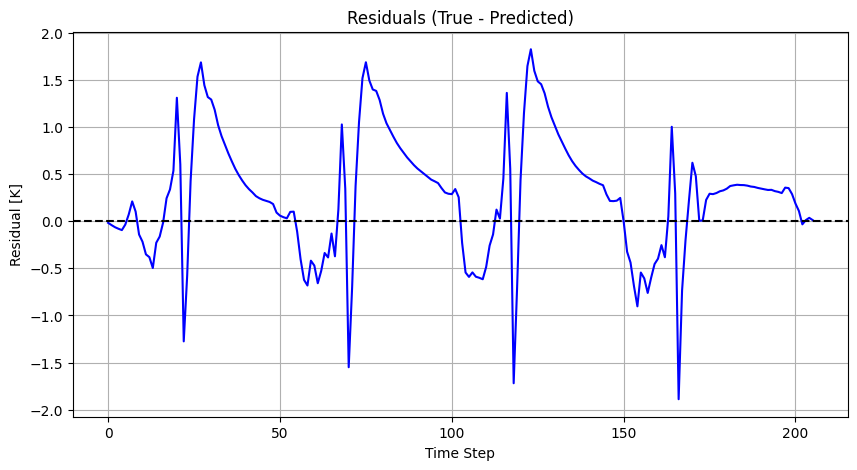

In [32]:
# --- Bounds ---
bounds_2r2c_A = {
    "R_e_a": (0.001, 1),
    "R_in_e": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.001, 0.3 * surface_area),
    "Ae": (0.001, 0.3 * surface_area),
    "fh": (0,1)
}

# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="2R2C_A",
    bounds=bounds_2r2c_A,
    show_plot=True
)

# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true, val_pred = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="2R2C_A",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Training RMSE: {np.sqrt(model.obj()):.4f}")
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)


In [33]:
best_model, best_parameters, best_initialization, all_trials = train_greybox_model(
    train_df=train_df,
    model_type="2R2C_A",    # ➔ Select the model type you want to train
    bounds=bounds_2r2c_A,   # ➔ The bounds you want to use
    solver_name="ipopt",  # ➔ What solver you want to use
    num_trials=5,        # ➔ How many trials you want to run
    deltaT=1800,          # ➔ The time step of the data in seconds
    show_plot=False        # ➔ If you want to show the plot of the models (True/False
)

all_trials_2r2c=all_trials.copy()

[Trial 1] RMSE = 0.5080, Init: {'R_e_a': 0.8076327150088984, 'R_in_e': 0.8961952086235697, 'C_in': 159683734.01096007, 'C_e': 55915910.339310706, 'Ain': 3.89846334430466, 'Ae': 7.304116077720356, 'fh': 0.8180147659224931}
 parameters: {'R_in_e': 0.0018466922251544082, 'R_e_a': 0.00197356549803531, 'C_in': 9136414.59563763, 'C_e': 365906441.4714253, 'Ain': 3.2202238098127443, 'Ae': 13.841535417794574, 'fh': 0.9052527456129563, 'Objective': 0.258104199624514, 'Solve_time': 0.4988067150115967}
[Trial 2] RMSE = 0.7540, Init: {'R_e_a': 0.8608698526730871, 'R_in_e': 0.007945178400659513, 'C_in': 255862903.9862053, 'C_e': 209288090.57124072, 'Ain': 3.7988214512390157, 'Ae': 2.050577916038642, 'fh': 0.33761517140362796}
 parameters: {'R_in_e': 0.000999990042833046, 'R_e_a': 0.0009999903972135835, 'C_in': 197819768.8356968, 'C_e': 296855415.97993684, 'Ain': 17.099999954204037, 'Ae': 0.5471477062718871, 'fh': 0.9999996348007573, 'Objective': 0.5684933267029094, 'Solve_time': 0.2646818161010742}


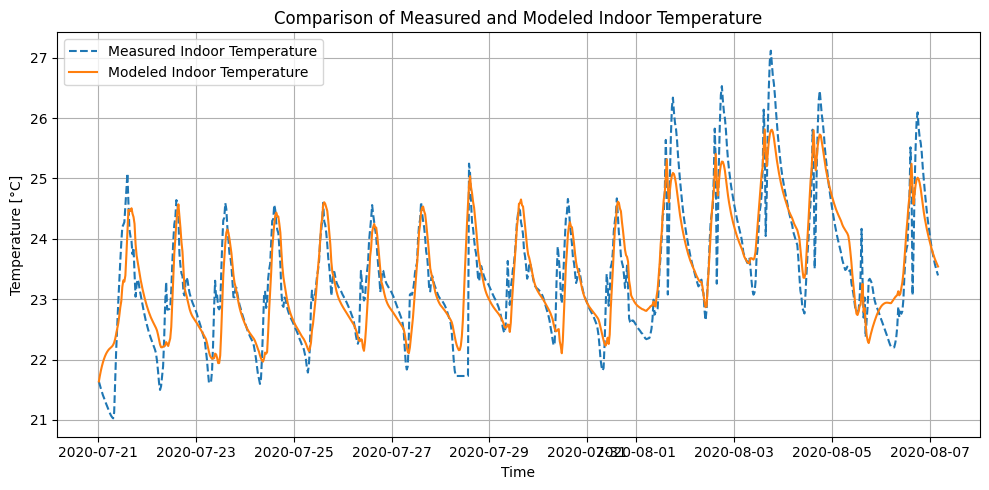

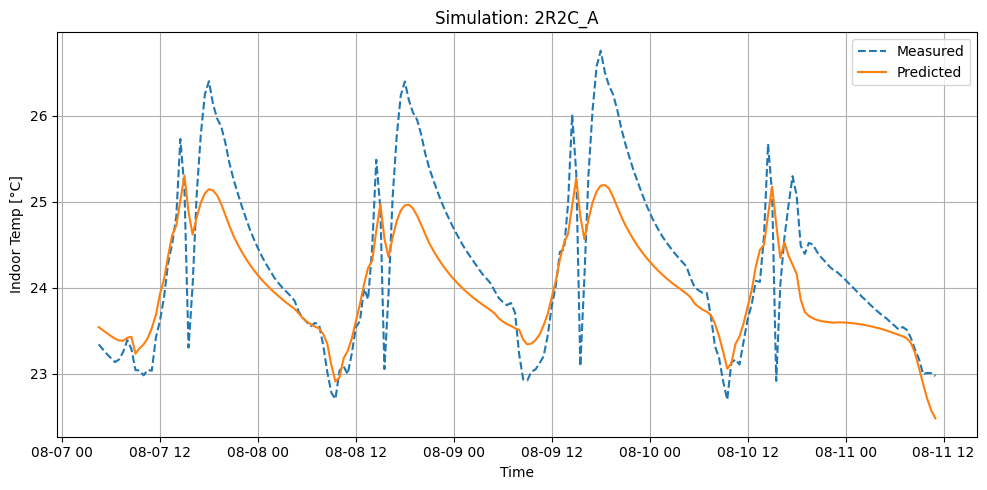

Training RMSE: 0.5051
Validation RMSE: 0.5951


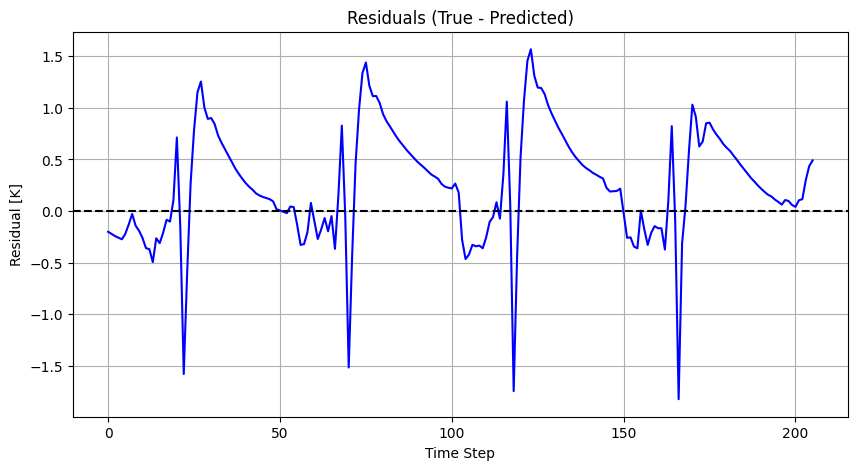

In [34]:
# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="2R2C_A",
    bounds=bounds_2r2c_A,
    initialization=best_initialization,
    show_plot=True
)

# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true, val_pred = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="2R2C_A",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Training RMSE: {np.sqrt(model.obj()):.4f}")
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)

# Q_h_estimated = simulate_Qh(val_df, parameters, initialize_validation, model_type="2R2C_A", deltaT=1800, show_plot=True)

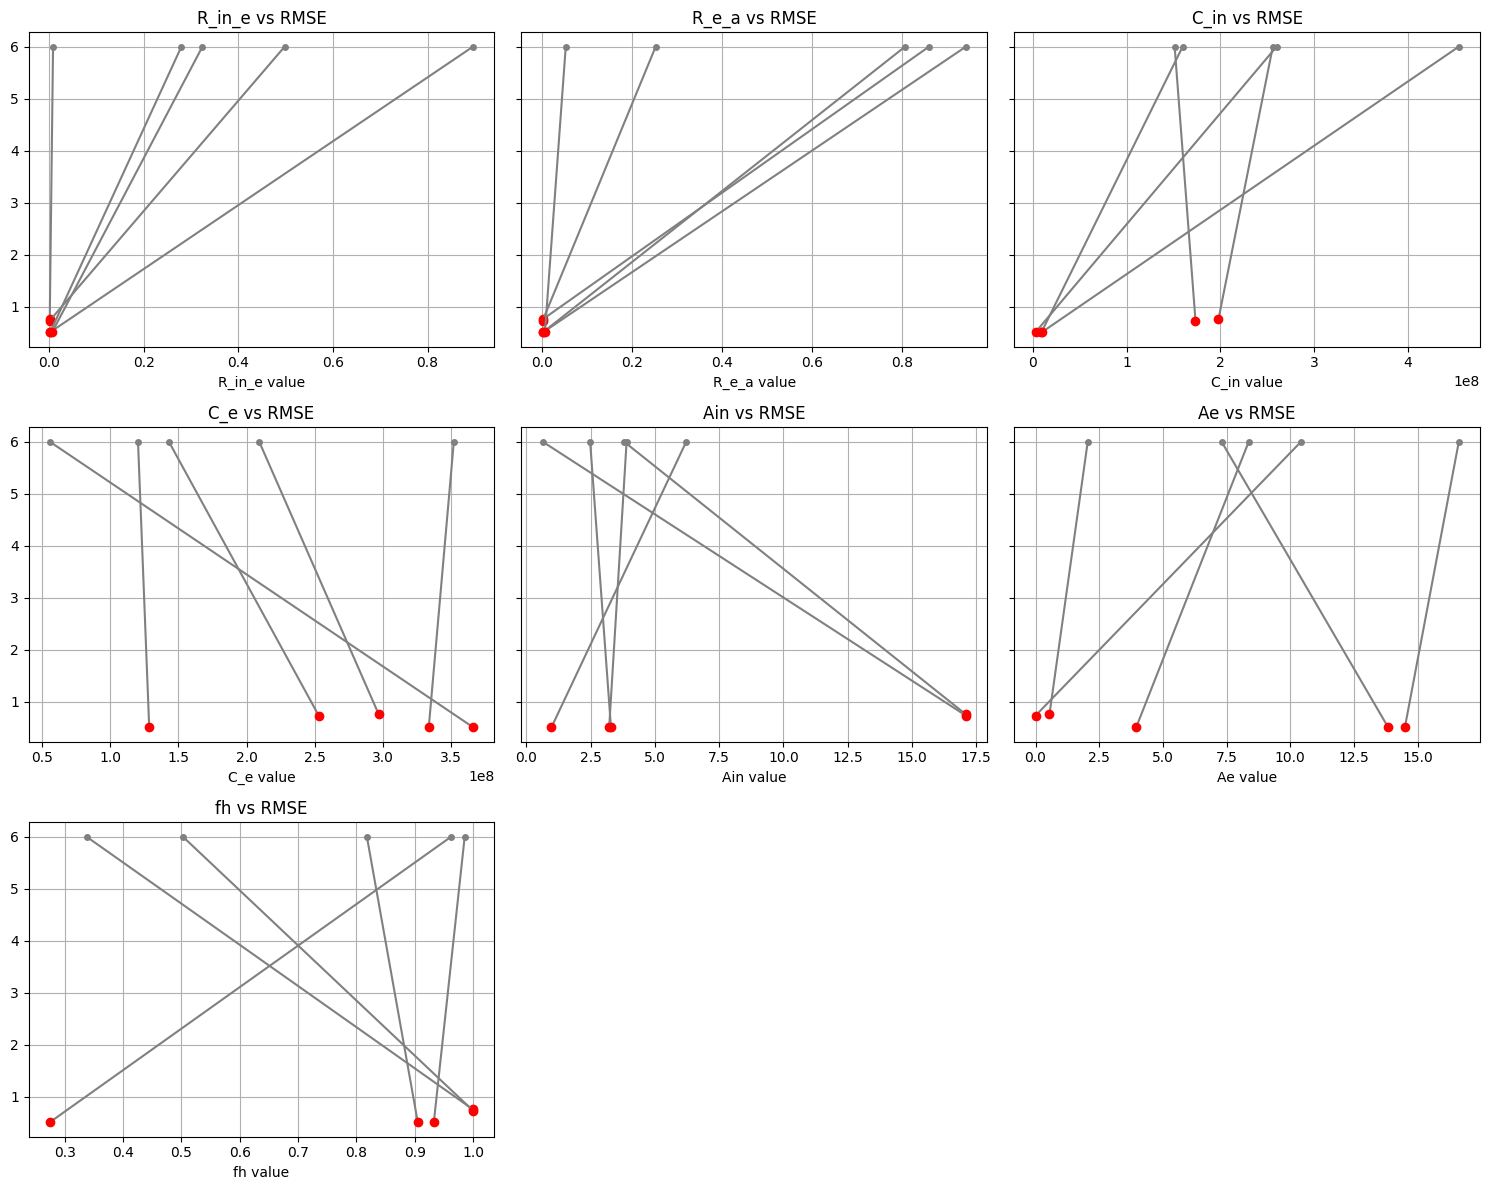

Best Objective achieved in 1 out of 5 trials.
Success rate: 20.00%
Best Objective was equal to 0.2550862147035585
Mean RMSE: 0.37
RMSE Std. Dev.: 0.16


In [35]:
param_list = ['R_in_e','R_e_a', 'C_in', 'C_e', 'Ain', 'Ae', 'fh']

plot_parameters_vs_rmse_multi(all_trials_2r2c, param_list, y_start=6, rmse_threshold=6)

# Calculate the best (lowest) objective value found
best_obj = all_trials_2r2c['Objective'].min()
mean_obj = all_trials_2r2c["Objective"].mean()
std_obj = all_trials_2r2c["Objective"].std()

# Check how many trials match this objective value up to 6 decimal places
# This allows for small numerical tolerance in floating-point comparisons
matches = (np.round(all_trials_2r2c['Objective'], 5) == np.round(best_obj, 5))

# Count how many times the best value was achieved (within tolerance)
n_matches = matches.sum()

# Total number of trials (rows)
n_total = len(all_trials_2r2c)

# Calculate success rate in percentage
success_rate = 100 * n_matches / n_total

# Print a summary message
print(f"Best Objective achieved in {n_matches} out of {n_total} trials.")
print(f"Success rate: {success_rate:.2f}%")
print(f"Best Objective was equal to {best_obj}")
print(f"Mean RMSE: {mean_obj:.2f}")
print(f"RMSE Std. Dev.: {std_obj:.2f}")


### The third Model is the 3R2C. The same process will be made.

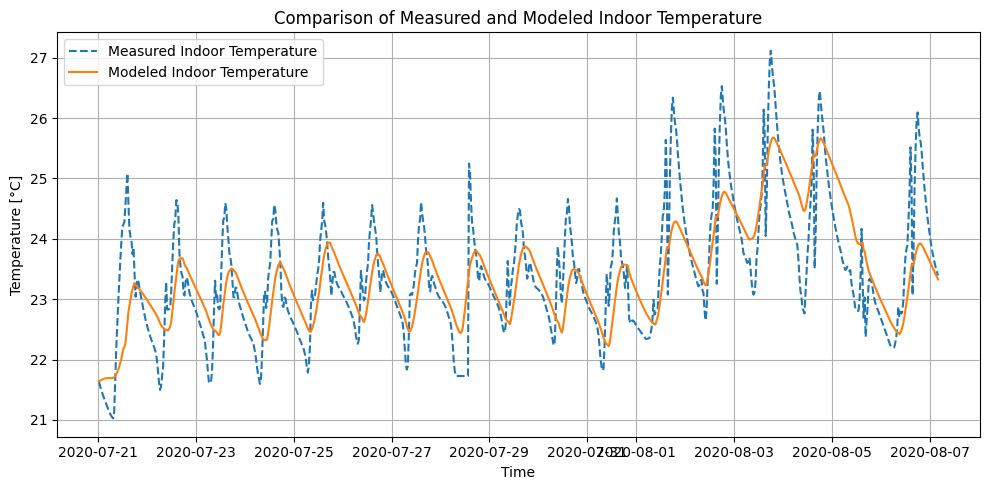

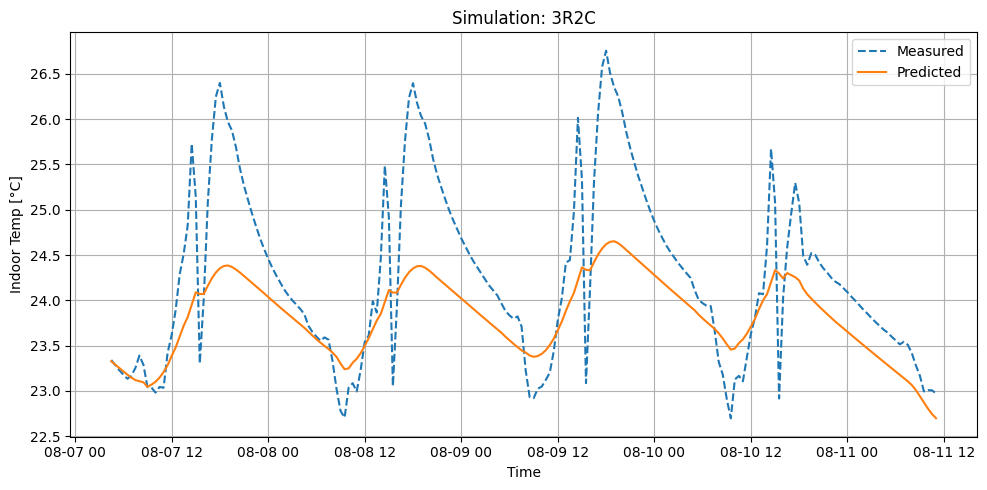

Training RMSE: 0.7233
Validation RMSE: 0.7769


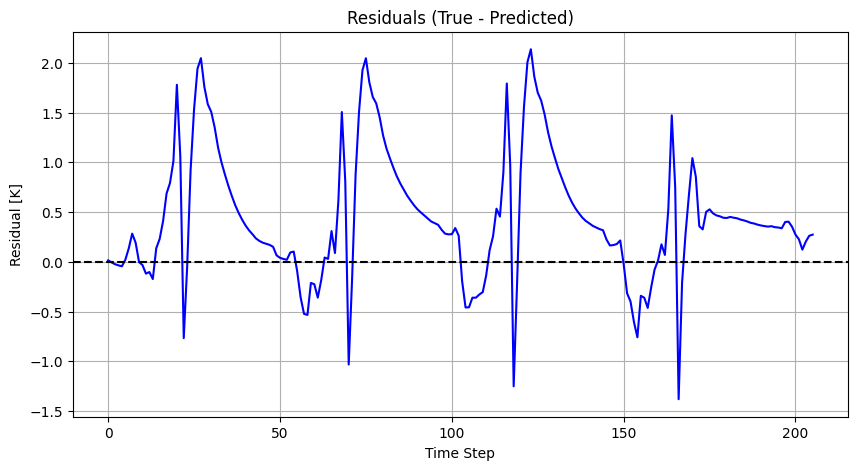

In [36]:
# --- Bounds ---
bounds_3r2c = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * surface_area),
    "Ae": (0.0001, 0.3 * surface_area),
    "fh": (0,1)
}

# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="3R2C",
    bounds=bounds_3r2c,
    show_plot=True
)

# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true, val_pred = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="3R2C",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Training RMSE: {np.sqrt(model.obj()):.4f}")
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)


In [37]:
best_model, best_parameters, best_initialization, all_trials = train_greybox_model(
    train_df=train_df,
    model_type="3R2C",    # ➔ Select the model type you want to train
    bounds=bounds_3r2c,   # ➔ The bounds you want to use
    solver_name="ipopt",  # ➔ What solver you want to use
    num_trials=5,        # ➔ How many trials you want to run
    deltaT=1800,          # ➔ The time step of the data in seconds
    show_plot=False        # ➔ If you want to show the plot of the models (True/False
)
all_trials_3r2c=all_trials.copy()

[Trial 1] RMSE = 0.7230, Init: {'R_in_e': 0.24281321623998892, 'R_e_a': 0.6724634118584727, 'R_in_a': 0.7618579957133889, 'C_in': 119581134.45220743, 'C_e': 364379957.95731795, 'Ain': 6.2891547911859575, 'Ae': 10.812466472567149, 'fh': 0.6335297107608947}
 parameters: {'R_in_e': 0.1150015787014385, 'R_e_a': 0.004502588621928149, 'R_in_a': 0.07153266553643728, 'C_in': 12141647.024888854, 'C_e': 15088903.435210379, 'Ain': 1.3927647917240733, 'Ae': 0.00010013350580932888, 'fh': 0.269735588207271, 'Objective': 0.5226740158911619, 'Solve_time': 1.1077499389648438}
[Trial 2] RMSE = 0.6642, Init: {'R_in_e': 0.5362389093906837, 'R_e_a': 0.0911994802843539, 'R_in_a': 0.8354671930936487, 'C_in': 161069252.42089617, 'C_e': 94072736.68952726, 'Ain': 0.6973508430723074, 'Ae': 10.104310239224615, 'fh': 0.6775643618422824}
 parameters: {'R_in_e': 0.0058075947948907514, 'R_e_a': 0.9999974928560214, 'R_in_a': 0.062354577562530156, 'C_in': 22096071.09611078, 'C_e': 3218563.7648163973, 'Ain': 3.013444450

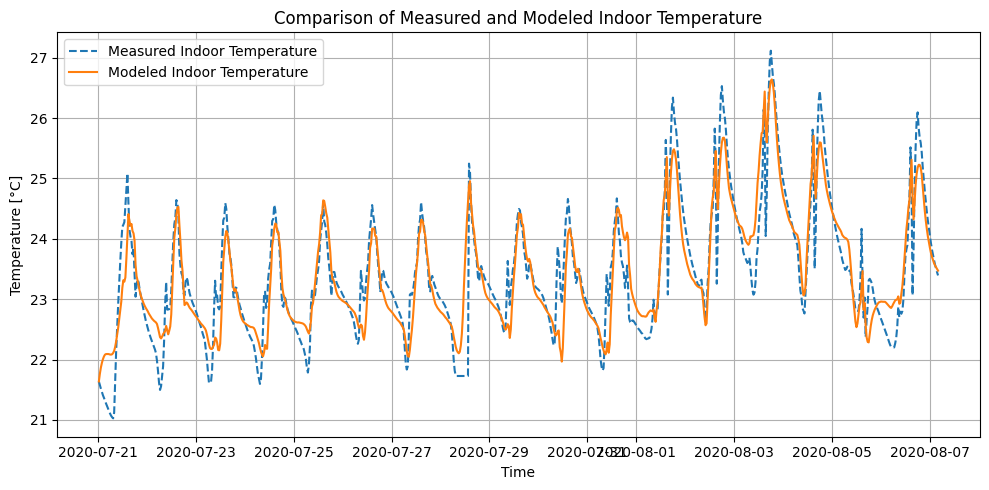

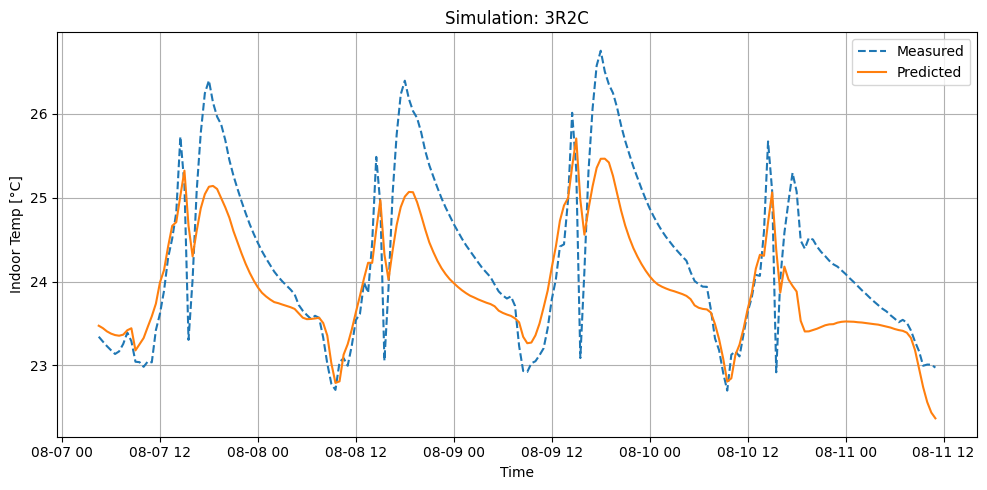

Training RMSE: 0.4705
Validation RMSE: 0.6219


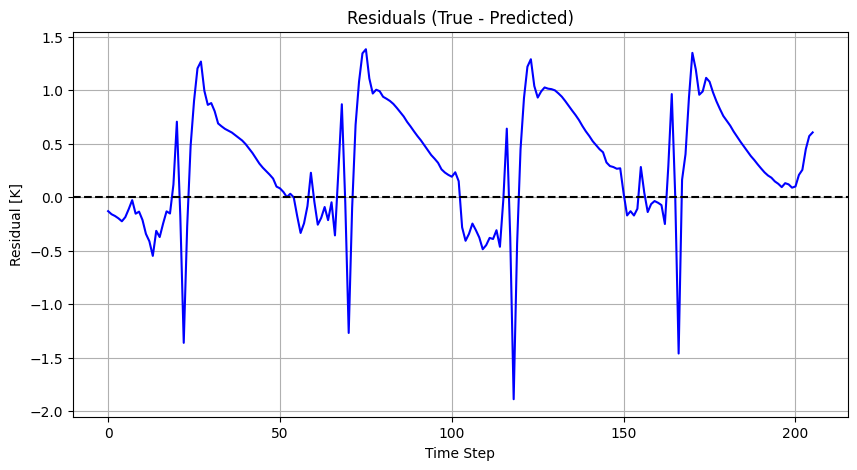

In [38]:
# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="3R2C",
    bounds=bounds_3r2c,
    initialization=best_initialization,
    show_plot=True
)

# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tint": model.T_int[last_index](),"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true, val_pred = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="3R2C",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Training RMSE: {np.sqrt(model.obj()):.4f}")
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)


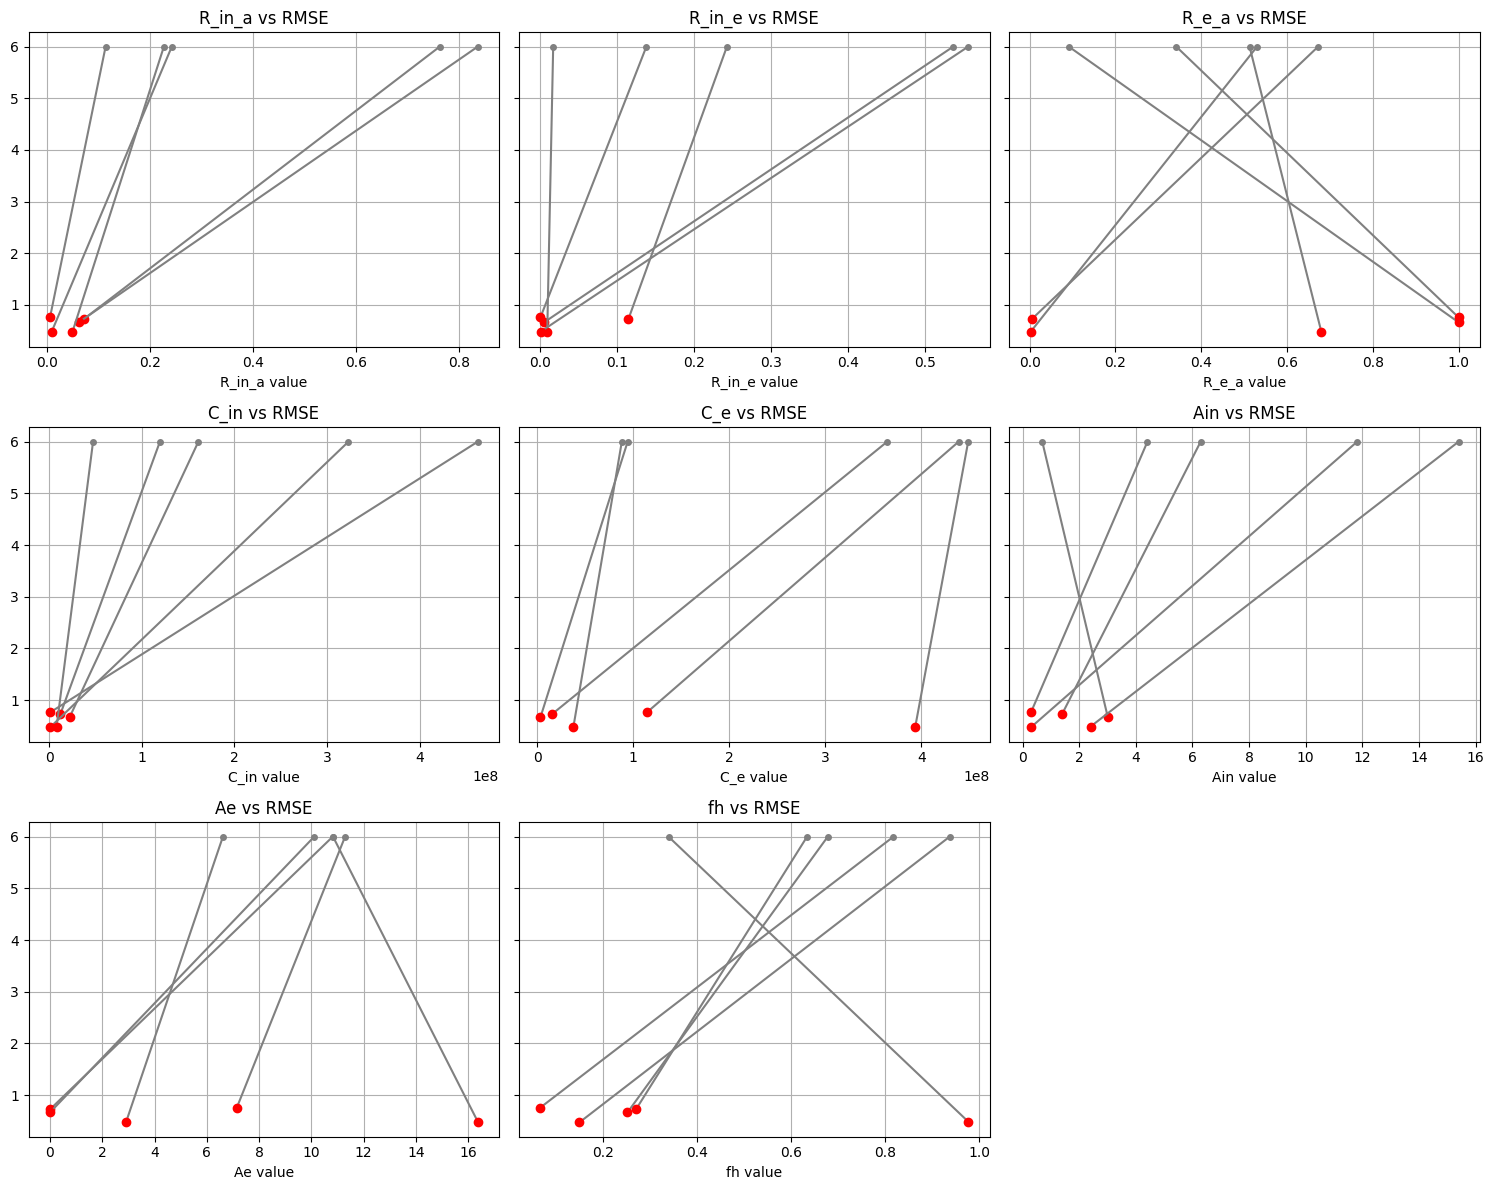

Best Objective achieved in 1 out of 5 trials.
Success rate: 20.00%
Best Objective was equal to 0.2213742567297741
Mean RMSE: 0.40
RMSE Std. Dev.: 0.16


In [39]:
param_list = ['R_in_a','R_in_e','R_e_a', 'C_in', 'C_e', 'Ain', 'Ae', 'fh']

plot_parameters_vs_rmse_multi(all_trials_3r2c, param_list, y_start=6, rmse_threshold=6)

# Calculate the best (lowest) objective value found
best_obj = all_trials_3r2c['Objective'].min()
mean_obj = all_trials_3r2c["Objective"].mean()
std_obj = all_trials_3r2c["Objective"].std()

# Check how many trials match this objective value up to 6 decimal places
# This allows for small numerical tolerance in floating-point comparisons
matches = (np.round(all_trials_3r2c['Objective'], 5) == np.round(best_obj, 5))

# Count how many times the best value was achieved (within tolerance)
n_matches = matches.sum()

# Total number of trials (rows)
n_total = len(all_trials_3r2c)

# Calculate success rate in percentage
success_rate = 100 * n_matches / n_total

# Print a summary message
print(f"Best Objective achieved in {n_matches} out of {n_total} trials.")
print(f"Success rate: {success_rate:.2f}%")
print(f"Best Objective was equal to {best_obj}")
print(f"Mean RMSE: {mean_obj:.2f}")
print(f"RMSE Std. Dev.: {std_obj:.2f}")

### The forth Model is the 4R3C. The same process will be made.

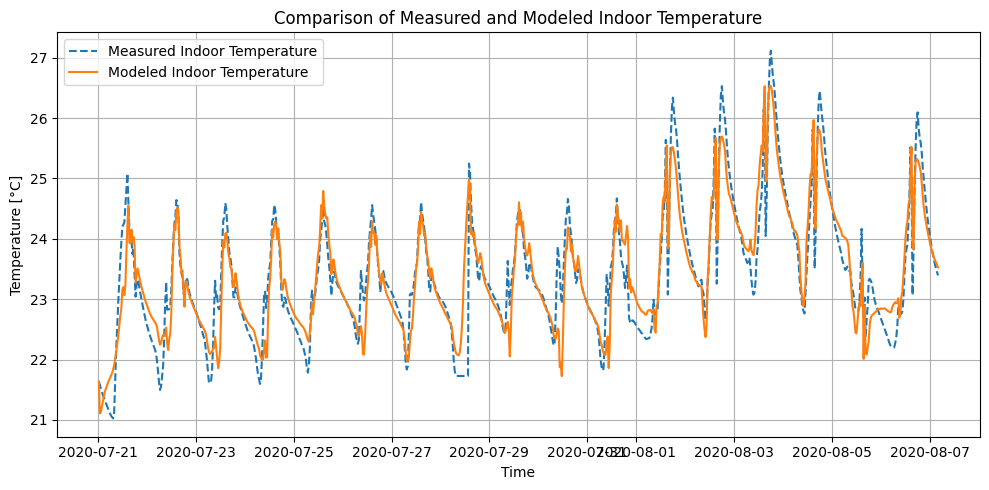

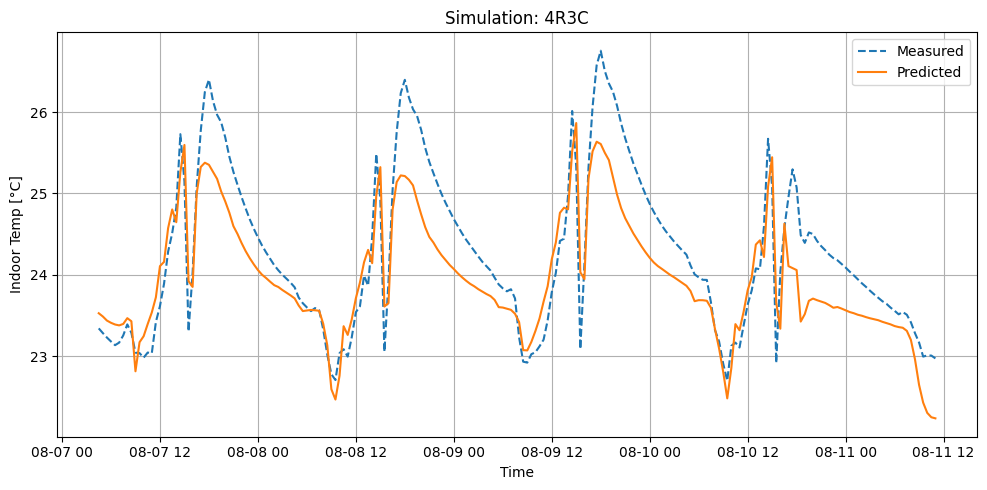

Training RMSE: 0.4368
Validation RMSE: 0.5365


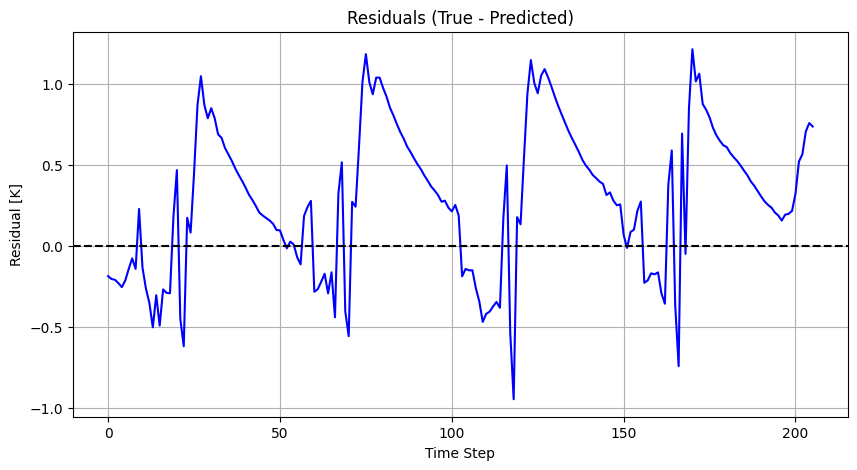

In [40]:
# --- Bounds ---
bounds_4r3c = {
    "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * surface_area),
    "Ain": (0.0001, 0.3 * surface_area),
    "Ae": (0.0001, 0.3 * surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}

# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="4R3C",
    bounds=bounds_4r3c,
    show_plot=True
)

# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tint": model.T_int[last_index](),"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true, val_pred = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="4R3C",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Training RMSE: {np.sqrt(model.obj()):.4f}")
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)


In [41]:
best_model, best_parameters, best_initialization, all_trials = train_greybox_model(
    train_df=train_df,
    model_type="4R3C",    # ➔ Select the model type you want to train
    bounds=bounds_4r3c,   # ➔ The bounds you want to use
    solver_name="ipopt",  # ➔ What solver you want to use
    num_trials=5,        # ➔ How many trials you want to run
    deltaT=1800,          # ➔ The time step of the data in seconds
    show_plot=False        # ➔ If you want to show the plot of the models (True/False
)
all_trials_4r3c=all_trials.copy()

[Trial 1] RMSE = 0.5741, Init: {'R_int_in': 0.3505111554634356, 'R_in_e': 0.7265037675124989, 'R_e_a': 0.8973160394326719, 'R_in_a': 0.8873122514165871, 'C_int': 390201922.2737828, 'C_in': 321445385.1017587, 'C_e': 43169014.53953036, 'Aint': 2.763934848146486, 'Ain': 15.365286768394201, 'Ae': 10.36997627727302, 'fh_int': 0.009197051616629648, 'fh_in': 0.1014715428660321, 'fh_e': 0.6635017691080558}
 parameters: {'R_int_in': 0.001999990232979087, 'R_in_e': 0.0019999901894437603, 'R_e_a': 0.004366658082972438, 'R_in_a': 0.00716236587424613, 'C_int': 380354418.27818537, 'C_in': 42909673.92330057, 'C_e': 143800150.21007404, 'Aint': 6.564697505245226, 'Ain': 6.57158516238489, 'Ae': 0.00010322556334151726, 'fh_int': 7.148817066000399e-08, 'fh_in': 0.9999998505968832, 'fh_e': 7.791494608930388e-08, 'Objective': 0.32961879995136806, 'Solve_time': 1.167389154434204}
[Trial 2] RMSE = 0.4368, Init: {'R_int_in': 0.00705146067852625, 'R_in_e': 0.16248643531466367, 'R_e_a': 0.5496363217878529, 'R_in

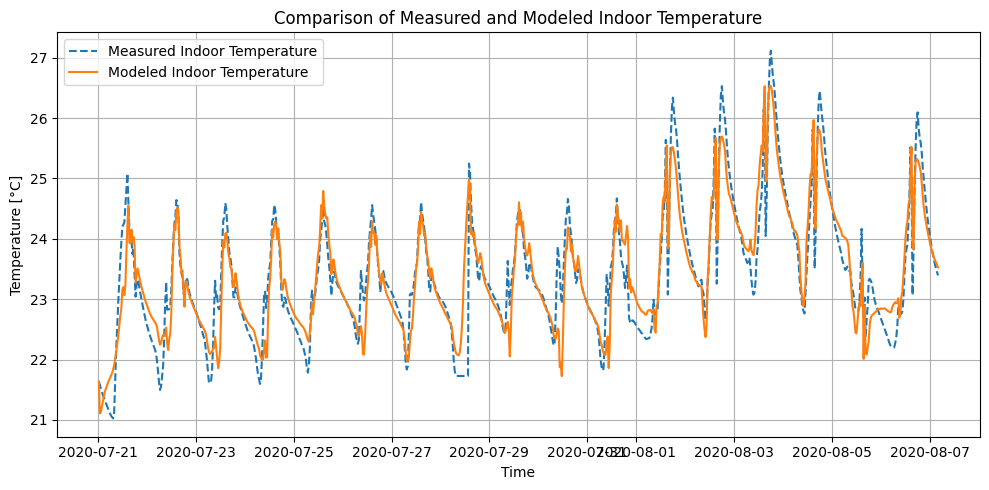

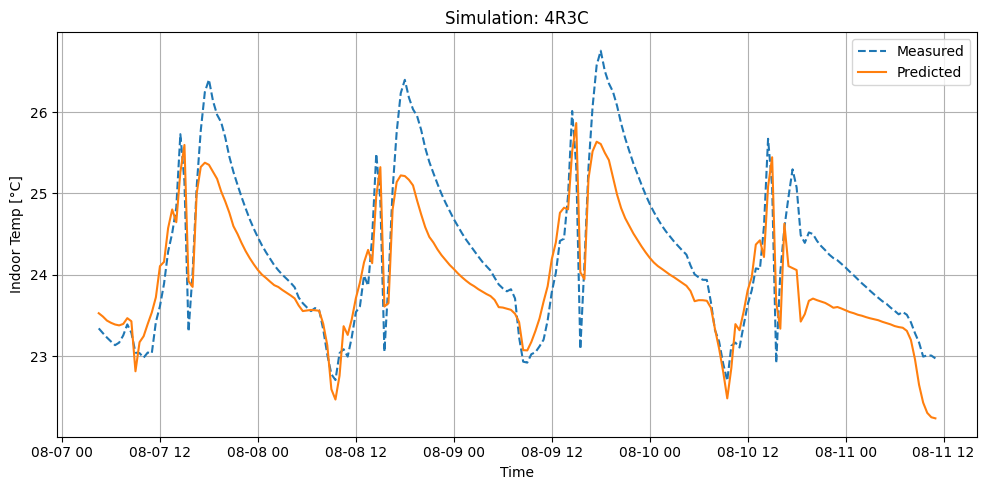

Training RMSE: 0.4368
Validation RMSE: 0.5365


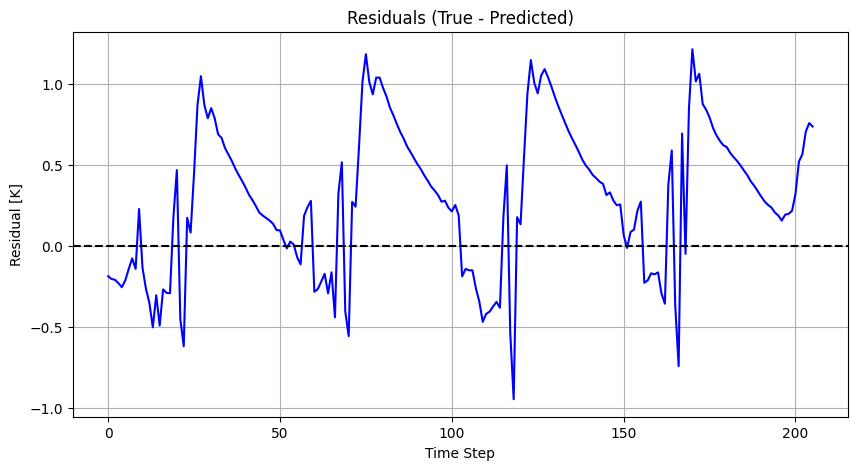

In [42]:
# --- Build and Solve Model ---
model, parameters = build_greybox_model(
    train_df=train_df,
    model_type="4R3C",
    bounds=bounds_4r3c,
    initialization=best_initialization,
    show_plot=True
)

# --- Validation Initialization (from last training value) ---
initialize_validation = {"Tint": model.T_int[last_index](),"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

# --- Run Simulation and Validation ---
validation, t_pred, t_true, val_pred = simulate_and_evaluate(
    val_df=val_df,
    param_dict=parameters,
    model_type="4R3C",
    initializations=initialize_validation,
    show_plot=True
)

# --- Results ---
print(f"Training RMSE: {np.sqrt(model.obj()):.4f}")
print(f"Validation RMSE: {validation['RMSE']:.4f}")

# --- Plot Residuals ---
plot_residual(t_pred=t_pred, t_true=t_true)

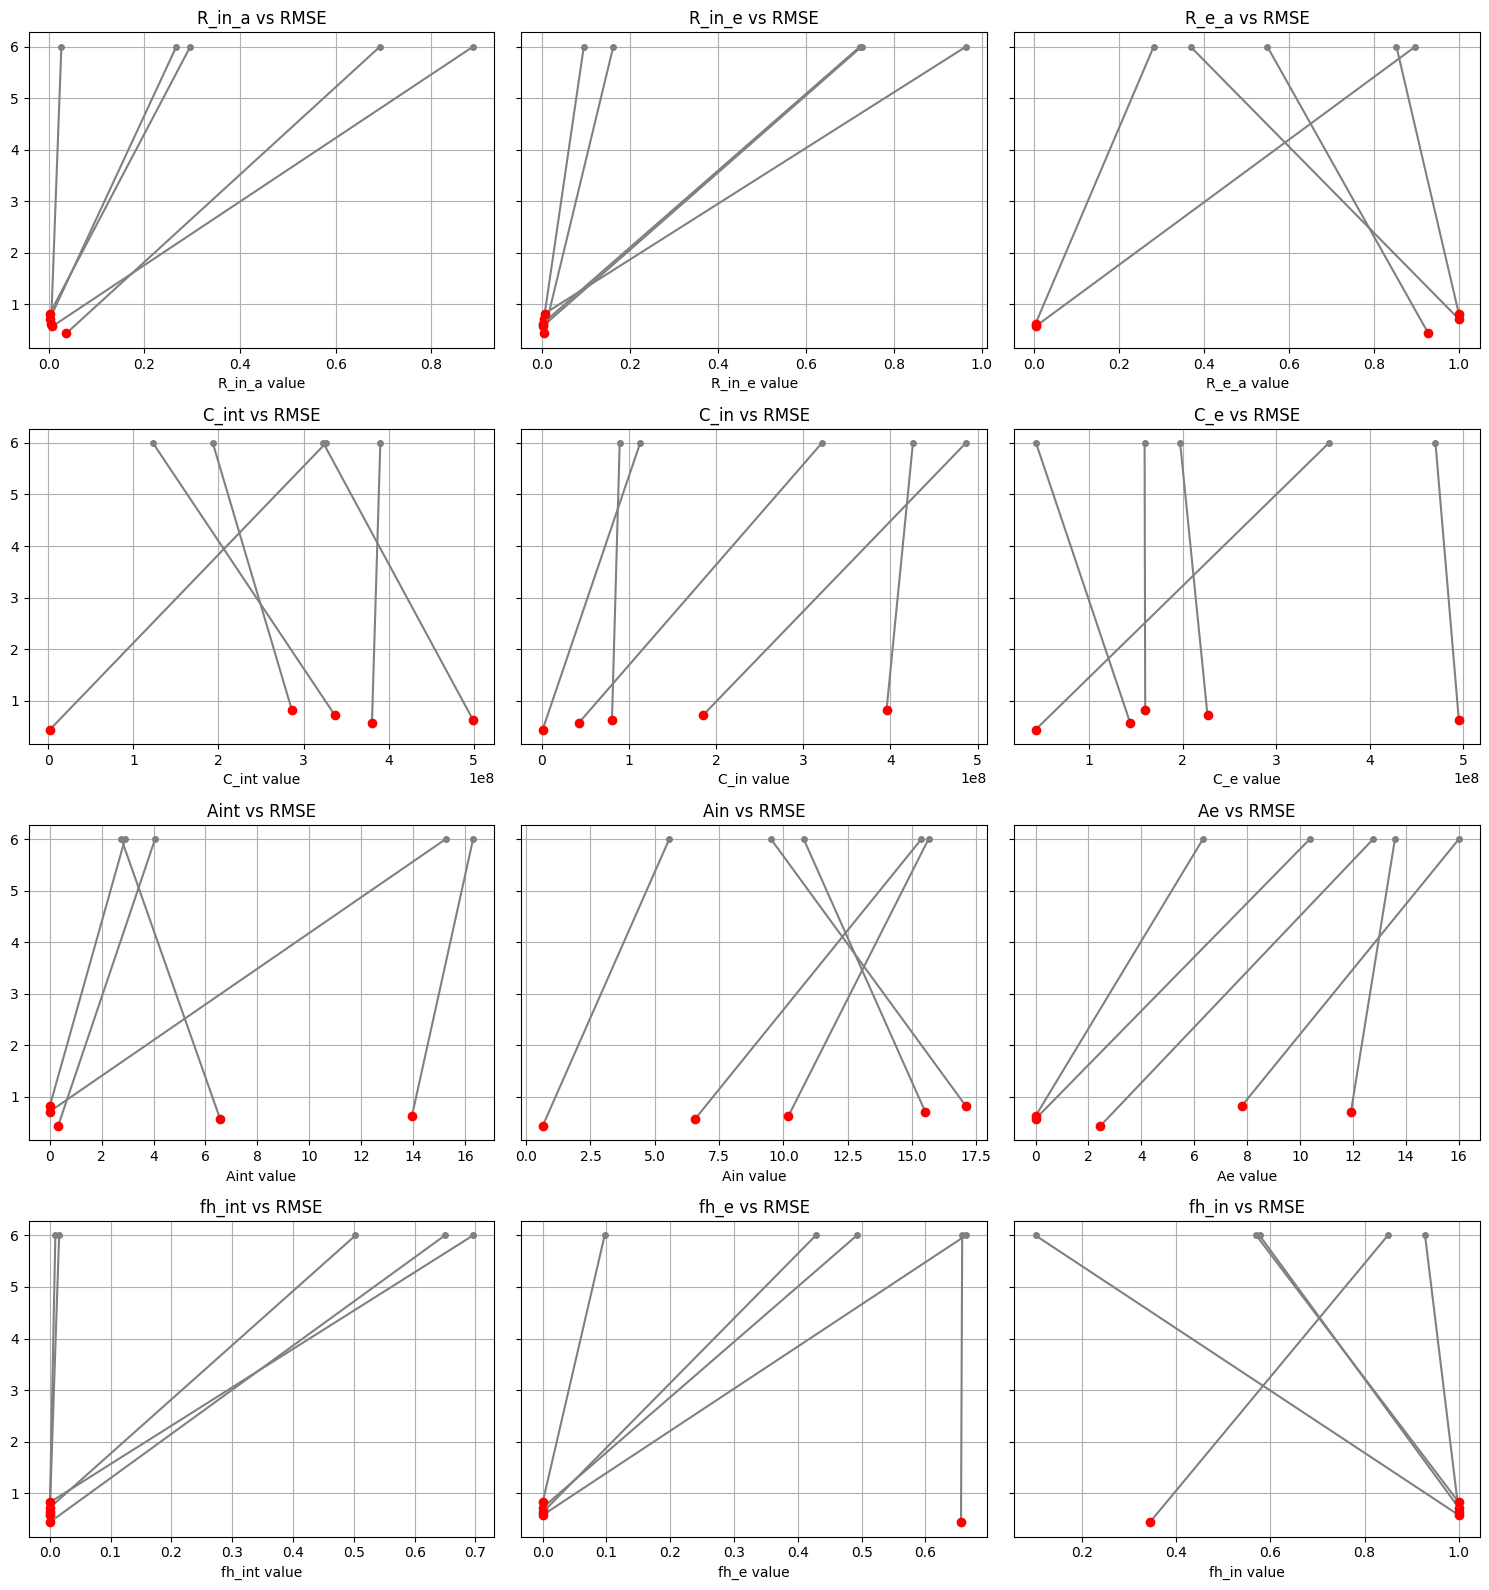

Best Objective achieved in 1 out of 5 trials.
Success rate: 20.00%
Best Objective was equal to 0.19077408531055892
Mean RMSE: 0.42
RMSE Std. Dev.: 0.18


In [43]:
param_list = ['R_in_a','R_in_e','R_e_a', 'C_int','C_in', 'C_e', 'Aint', 'Ain', 'Ae', 'fh_int', 'fh_e', 'fh_in']

plot_parameters_vs_rmse_multi(all_trials_4r3c, param_list, y_start=6, rmse_threshold=6)

# Calculate the best (lowest) objective value found
best_obj = all_trials_4r3c['Objective'].min()
mean_obj = all_trials_4r3c["Objective"].mean()
std_obj = all_trials_4r3c["Objective"].std()

# Check how many trials match this objective value up to 6 decimal places
# This allows for small numerical tolerance in floating-point comparisons
matches = (np.round(all_trials_4r3c['Objective'], 5) == np.round(best_obj, 5))

# Count how many times the best value was achieved (within tolerance)
n_matches = matches.sum()

# Total number of trials (rows)
n_total = len(all_trials_4r3c)

# Calculate success rate in percentage
success_rate = 100 * n_matches / n_total

# Print a summary message
print(f"Best Objective achieved in {n_matches} out of {n_total} trials.")
print(f"Success rate: {success_rate:.2f}%")
print(f"Best Objective was equal to {best_obj}")
print(f"Mean RMSE: {mean_obj:.2f}")
print(f"RMSE Std. Dev.: {std_obj:.2f}")